# Cycle Gan Implementation

In [1]:
# import relevant libraries
# TODO: in the end, check if any of them are unused -> if yes, delete the respective imports
import functools
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.io
import struct
import tensorflow as tf
%matplotlib inline

In [2]:
# helper functions
# TODO: maybe delete some of them, if not needed
# We will define functions for the layers so our code is not redundant.

def feed_forward_layer(x, hidden_n, activation_fn, normalize):        
    initializer = tf.random_normal_initializer(stddev=0.02)

    weights = tf.get_variable("weights", [x.shape[1], hidden_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [hidden_n], tf.float32, tf.zeros_initializer())
    
    drive = tf.matmul(x, weights) + biases
    
    if normalize:
        drive = batch_norm(drive, [0])
    
    if activation_fn == 'linear':
        return drive
    else:
        return activation_fn(drive)



def conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize, pad="SAME"):
    initializer = tf.random_normal_initializer(stddev=0.02)
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, x.shape[-1], kernels_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [kernels_n], tf.float32, tf.zeros_initializer())
    
    # valid padding, because no additional padding is necessary (reflection padding has already been applied)
    drive = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = pad) + biases
    
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    if activation_fn == 'linear':
        return drive
    else:
        return activation_fn(drive)




def back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize, pad="SAME"):
    initializer = tf.random_normal_initializer(stddev=0.02)
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], x.shape[-1]], tf.float32, initializer)
    biases = tf.get_variable("biases", [target_shape[-1]], tf.float32, tf.zeros_initializer())
    #TODO: Maybe change padding back to same
    drive = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1], padding = pad) + biases
    
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])

# TODO: instance normalization instead of batch normalization

def batch_norm(x, axes):
    mean, var = tf.nn.moments(x, axes = axes)
    
    offset_initializer = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [x.shape[-1]], tf.float32, offset_initializer)
    scale_initializer = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [x.shape[-1]], tf.float32, scale_initializer)
    
    return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

def residual_block(x, scope):
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        #apply reflection padding
        res_block = tf.pad(x, [[0,0,], [1,1,], [1,1,], [0,0,]], "REFLECT")
        res_block = conv_layer(res_block, 256, 3, 1, tf.nn.relu, True, pad="VALID")
        #res_block = conv_layer(res_block, 128, 3, 1, tf.nn.relu, True, pad="VALID")
        res_block = tf.pad(res_block, [[0,0,], [1,1,], [1,1,], [0,0,]], "REFLECT")
        res_block = conv_layer(res_block, 256, 3, 1, "linear", True, pad="VALID")
        #res_block = conv_layer(res_block, 128, 3, 1, "linear", True, pad="VALID")
        return tf.nn.relu(res_block + x)
    

In [3]:
# read MNIST data (only training data)
# TODO: maybe add and process test data
# our domain X
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
mnist_images = read_idx('./MNIST/train-images-idx3-ubyte')
mnist_labels = read_idx('./MNIST/train-labels-idx1-ubyte')

# Normalize the training data.
print(mnist_images.shape)
mnist_images = np.expand_dims(mnist_images, 3)
print(mnist_images.shape)
normalized_mnist_images = (mnist_images / 255) * 2 - 1

(60000, 28, 28)
(60000, 28, 28, 1)


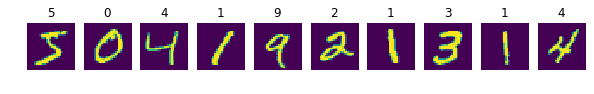

In [4]:
# show some mnist images with labels
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(mnist_images[i,:,:,0])
    ax[i].axis('off')
    ax[i].set_title(mnist_labels[i])

In [5]:
# read SVHN data (only training data)
# TODO: maybe add test data
# our domain Y

def load_svhn(path):
    
    matfile = scipy.io.loadmat(path)
    images = matfile['X']
    images = np.expand_dims(images,0)
    images = np.swapaxes(images, 0,4)
    images = np.squeeze(images)
    labels = matfile['y']
    labels = np.squeeze(labels)
    print(len(labels))
    
    svhn_images = images[10000:,:,:,:]
    svhn_labels = labels[10000:]
    
    print(svhn_images.shape)
    
    return svhn_images, svhn_labels


svhn_images, svhn_labels = load_svhn('./SVHN/train_32x32.mat')

normalized_svhn_images = (svhn_images / 255) * 2 - 1

73257
(63257, 32, 32, 3)


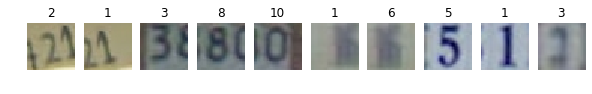

In [6]:
# show some svhn images with labels
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(svhn_images[i,:,:,0:3])
    ax[i].axis('off')
    ax[i].set_title(svhn_labels[i])

In [7]:
# Define the hyperparameters of the model.

batch_size = 1
#batch_size = 50

image_buffer_size = 50





In [8]:
tf.reset_default_graph()

# Create the datasets.
mnist_dataset = tf.data.Dataset.from_tensor_slices((normalized_mnist_images, mnist_labels))
svhn_dataset = tf.data.Dataset.from_tensor_slices((normalized_svhn_images, svhn_labels))


# Shuffle the training data in each iteration.
mnist_dataset = mnist_dataset.shuffle(buffer_size = 60000)
svhn_dataset = svhn_dataset.shuffle(buffer_size = 73257)

# Specify the batch sizes.
mnist_dataset = mnist_dataset.batch(batch_size, drop_remainder=True)
svhn_dataset = svhn_dataset.batch(batch_size, drop_remainder=True)

In [9]:
# Create the iterators.
mnist_iterator = tf.data.Iterator.from_structure(mnist_dataset.output_types,
                                           mnist_dataset.output_shapes)
svhn_iterator = tf.data.Iterator.from_structure(svhn_dataset.output_types,
                                           svhn_dataset.output_shapes)

# Name the operations that will give the next batch and name the 
# initialization operations.
next_batch_mnist = mnist_iterator.get_next()
next_batch_svhn = svhn_iterator.get_next()

training_init_op_mnist = mnist_iterator.make_initializer(mnist_dataset)
training_init_op_svhn = svhn_iterator.make_initializer(svhn_dataset)

# Generators

In [10]:
# From the paper: 
#Let c7s1-k denote a 7 × 7 Convolution-InstanceNorm- ReLU layer with k filters and stride 1. 
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. 
#Reflection padding was used to reduce artifacts. 
#Rk denotes a residual block that contains two 3 × 3 con- volutional layers with the same number of filters 
#on both layer. uk denotes a 3 × 3 fractional-strided-Convolution- InstanceNorm-ReLU layer with k filters 
#and stride 1 .
#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,
#R256,R256,R256,u128,u64,c7s1-3

In [11]:
# generator G: X->Y

# TODO: maybe reduce numbers of kernels - runtime might be astronomical!
# TODO: maybe reduce duplicate code

mnist_real = tf.cast(next_batch_mnist[0], dtype=tf.float32)

#TODO: attention! probably wrong dimensions for padding -> needs to be corrected
# kernel size 7 -> padding 3

def G(mnist_real):
    # generator network
    with tf.variable_scope("G_first_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        # padding of 5 instead of 3 to compensate for different sizes of svhn and mnist images
        padded_mnist_input = tf.pad(mnist_real, [[0,0,], [5,5,], [5,5,], [0,0,]], "REFLECT")
        gen_G_layer_1 = conv_layer(padded_mnist_input, 64, 7, 1, tf.nn.relu, True, pad="VALID")

    with tf.variable_scope("G_downsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_G_layer_2 = conv_layer(gen_G_layer_1, 128, 3, 2, tf.nn.relu, True)
    with tf.variable_scope("G_downsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_G_layer_3 = conv_layer(gen_G_layer_2, 256, 3, 2, tf.nn.relu, True)

    #TODO: maybe remove variable scope for residual blocks
    with tf.variable_scope("G_residual_block_1", reuse=tf.AUTO_REUSE):
        #gen_G_layer_4 = residual_block(gen_G_layer_2, "G_residual_block_1")
        gen_G_layer_4 = residual_block(gen_G_layer_3, "G_residual_block_1")
    with tf.variable_scope("G_residual_block_2", reuse=tf.AUTO_REUSE):
        gen_G_layer_5 = residual_block(gen_G_layer_4, "G_residual_block_2")
    with tf.variable_scope("G_residual_block_3", reuse=tf.AUTO_REUSE):
        gen_G_layer_6 = residual_block(gen_G_layer_5, "G_residual_block_3")
    with tf.variable_scope("G_residual_block_4", reuse=tf.AUTO_REUSE):
        gen_G_layer_7 = residual_block(gen_G_layer_6, "G_residual_block_4")
    with tf.variable_scope("G_residual_block_5", reuse=tf.AUTO_REUSE):
        gen_G_layer_8 = residual_block(gen_G_layer_7, "G_residual_block_5")
    with tf.variable_scope("G_residual_block_6", reuse=tf.AUTO_REUSE):
        gen_G_layer_9 = residual_block(gen_G_layer_8, "G_residual_block_6")

    with tf.variable_scope("G_upsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_G_layer_10 = back_conv_layer(gen_G_layer_9, [batch_size, 16, 16, 128], 3, 2, tf.nn.relu, True)

    with tf.variable_scope("G_upsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_G_layer_11 = back_conv_layer(gen_G_layer_10, [batch_size, 32, 32, 64], 3, 2, tf.nn.relu, True)
        #gen_G_layer_11 = back_conv_layer(gen_G_layer_6, [batch_size, 32, 32, 64], 3, 2, tf.nn.relu, True)

    with tf.variable_scope("G_last_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        svhn_generated = tf.pad(gen_G_layer_11, [[0,0,], [3,3,], [3,3,], [0,0,]], "REFLECT")
        # TODO: not sure if really tanh, paper suggests otherwise, but pytorch implementation uses tanh (makes more sense)
        svhn_generated = conv_layer(svhn_generated, 3, 7, 1, tf.nn.tanh, True, pad="VALID")
    
    return svhn_generated

svhn_generated = G(mnist_real)

In [12]:
# generator F: Y->X

# TODO: maybe reduce numbers of kernels - runtime might be astronomical!
# TODO: maybe reduce duplicate code

svhn_real = tf.cast(next_batch_svhn[0], dtype=tf.float32)

#TODO: attention! probably wrong dimensions for padding -> needs to be corrected
# kernel size 7 -> padding 3

def F(svhn_real):
    # generator network
    with tf.variable_scope("F_first_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        padded_svhn_input = tf.pad(svhn_real, [[0,0,], [3,3,], [3,3,], [0,0,]], "REFLECT")
        gen_F_layer_1 = conv_layer(padded_svhn_input, 64, 7, 1, tf.nn.relu, True, pad="VALID")

    with tf.variable_scope("F_downsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_F_layer_2 = conv_layer(gen_F_layer_1, 128, 3, 2, tf.nn.relu, True)
    with tf.variable_scope("F_downsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_F_layer_3 = conv_layer(gen_F_layer_2, 256, 3, 2, tf.nn.relu, True)

    #TODO: maybe remove variable scope for residual blocks
    with tf.variable_scope("F_residual_block_1", reuse=tf.AUTO_REUSE):
        gen_F_layer_4 = residual_block(gen_F_layer_3, "F_residual_block_1")
    with tf.variable_scope("F_residual_block_2", reuse=tf.AUTO_REUSE):
        gen_F_layer_5 = residual_block(gen_F_layer_4, "F_residual_block_2")
    with tf.variable_scope("F_residual_block_3", reuse=tf.AUTO_REUSE):
        gen_F_layer_6 = residual_block(gen_F_layer_5, "F_residual_block_3")
    with tf.variable_scope("F_residual_block_4", reuse=tf.AUTO_REUSE):
        gen_F_layer_7 = residual_block(gen_F_layer_6, "F_residual_block_4")
    with tf.variable_scope("F_residual_block_5", reuse=tf.AUTO_REUSE):
        gen_F_layer_8 = residual_block(gen_F_layer_7, "F_residual_block_5")
    with tf.variable_scope("F_residual_block_6", reuse=tf.AUTO_REUSE):
        gen_F_layer_9 = residual_block(gen_F_layer_8, "F_residual_block_6")

    with tf.variable_scope("F_upsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_F_layer_10 = back_conv_layer(gen_F_layer_9, [batch_size, 16, 16, 128], 3, 2, tf.nn.relu, True)

    with tf.variable_scope("F_upsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_F_layer_11 = back_conv_layer(gen_F_layer_10, [batch_size, 32, 32, 64], 3, 2, tf.nn.relu, True)

    with tf.variable_scope("F_last_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        # padding of 1 instead of 3 to compensate for different sizes of mnist and svhn images
        mnist_generated = tf.pad(gen_F_layer_11, [[0,0,], [1,1,], [1,1,], [0,0,]], "REFLECT")
        # TODO: not sure if really tanh, paper suggests otherwise, but pytorch implementation uses tanh (makes more sense)
        # 1 instead of 3 kernels, because mnist images are grayscale
        mnist_generated = conv_layer(mnist_generated, 1, 7, 1, tf.nn.tanh, True, pad = "VALID")
        
    return mnist_generated

mnist_generated = F(svhn_real)
print(mnist_generated.shape)

(1, 28, 28, 1)


# Discriminators

In [13]:
# discriminator Dy (adversarial to generator G, encourages G to translate X into outputs indistinguishable from domain Y)
# tried to discriminate between real and generated svhn images
# TODO: replace "something" with discriminator input

#svhn_input: real svhn image
#svhn_output: generated svhn image
#TODO: variable names should start with non capital letters
#TODO Dy_input should be a placeholder and be feed with the generated image buffer and some real images (number same as current buffer size)
Dy_input = tf.concat([svhn_real, svhn_generated],0)
with tf.variable_scope("Dy_layer_C64", reuse=tf.AUTO_REUSE):
    #0.2 is default slope for leaky relu
    Dy_layer_1 = conv_layer(Dy_input, 64, 4, 2, tf.nn.leaky_relu, False, pad="SAME")
with tf.variable_scope("Dy_layer_C128", reuse=tf.AUTO_REUSE):
    Dy_layer_2 = conv_layer(Dy_layer_1, 128, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dy_layer_C256", reuse=tf.AUTO_REUSE):
    Dy_layer_3 = conv_layer(Dy_layer_2, 256, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dy_layer_C512", reuse=tf.AUTO_REUSE):
    Dy_layer_4 = conv_layer(Dy_layer_3, 512, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dy_output_layer", reuse=tf.AUTO_REUSE):
    Dy_output = conv_layer(Dy_layer_4, 1, 4, 2, tf.nn.tanh, True, pad="SAME")
    Dy_output = flatten(Dy_output)
print(Dy_output.shape)

(2, 1)


In [14]:
# discriminator Dx (adversarial to generator F, encourages F to translate Y into outputs indistinguishable from domain X)
# tried to discriminate between real and generated svhn images
#TODO: variable names should start with non capital letters
#TODO Dx_input should be a placeholder and be feed with the generated image buffer and some real images (number same as current buffer size)
Dx_input = tf.concat([mnist_real, mnist_generated],0)
with tf.variable_scope("Dx_layer_C64", reuse=tf.AUTO_REUSE):
    #0.2 is default slope for leaky relu
    Dx_layer_1 = conv_layer(Dx_input, 64, 4, 2, tf.nn.leaky_relu, False, pad="SAME")
with tf.variable_scope("Dx_layer_C128", reuse=tf.AUTO_REUSE):
    Dx_layer_2 = conv_layer(Dy_layer_1, 128, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dx_layer_C256", reuse=tf.AUTO_REUSE):
    Dx_layer_3 = conv_layer(Dy_layer_2, 256, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dx_layer_C512", reuse=tf.AUTO_REUSE):
    Dx_layer_4 = conv_layer(Dy_layer_3, 512, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dx_output_layer", reuse=tf.AUTO_REUSE):
    Dx_output = conv_layer(Dx_layer_4, 1, 4, 2, tf.nn.tanh, True, pad="SAME")
    Dx_output = flatten(Dx_output)
print(Dx_output.shape)

(2, 1)


# Loss and Optimizer functions

In [15]:
# discriminator losses
with tf.variable_scope("Dy_loss"):
    dy_labels = tf.concat([tf.ones([batch_size,1]), tf.zeros([batch_size,1])], axis=0)
    print(dy_labels.shape)
    dy_loss = tf.losses.mean_squared_error(dy_labels, Dy_output)
    dy_loss = tf.reduce_mean(dy_loss)
with tf.variable_scope("Dx_loss"):
    dx_labels = tf.concat([tf.ones([batch_size,1]), tf.zeros([batch_size,1])], axis=0)
    dx_loss = tf.losses.mean_squared_error(dx_labels, Dx_output)
    dx_loss = tf.reduce_mean(dx_loss)
    
# controls the relative importance of adversarial loss and cyclic loss
lambda_weight = 10

# gan loss for generators
one_labels = tf.ones([batch_size,1])
#TODO: maybe change, not sure if Dy_output[0:batch_size] does the right thing
g_gan_loss = tf.losses.mean_squared_error(one_labels, Dy_output[batch_size:, :])
g_gan_loss = tf.reduce_mean(g_gan_loss)
f_gan_loss = tf.losses.mean_squared_error(one_labels, Dx_output[batch_size:, :])
f_gan_loss = tf.reduce_mean(f_gan_loss)
    
# TODO: technically second parameter should be F(G(mnist_real)) and G(F(svhn_real)) but I hope to save calculation time
cycle_loss = tf.losses.absolute_difference(mnist_real, F(svhn_generated)) + tf.losses.absolute_difference(svhn_real, G(mnist_generated))
cycle_loss = tf.reduce_mean(cycle_loss)
 # TODO maybe reduce mean

# generator losses
with tf.variable_scope("G_loss"):
    g_loss = lambda_weight * cycle_loss + g_gan_loss
   
    
with tf.variable_scope("F_loss"):
    f_loss = lambda_weight * cycle_loss + f_gan_loss
    
# get the generator and discriminator variables
with tf.variable_scope("variables"):
    trainable_variables = tf.trainable_variables()
    dy_variables = [var for var in trainable_variables if "Dy_" in var.name]
    dx_variables = [var for var in trainable_variables if "Dx_" in var.name]
    g_variables = [var for var in trainable_variables if "G_" in var.name]
    #print(g_variables)
    f_variables = [var for var in trainable_variables if "F_" in var.name]
    
with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
    # variable learning rate, decay after 100 episodes
    learning_rate = tf.placeholder(tf.float32, [])
    beta1 = 0.5
    
    dy_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    dx_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    f_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    
    # use negative loss, because generator wants to maximize loss (i.e. works against discriminator)
    # TODO: might not work as intended, maybe change
    dy_training_step = dy_optimizer.minimize(dy_loss, var_list = dy_variables)
    # use negative loss, because generator wants to maximize loss (i.e. works against discriminator)
    # TODO: might not work as intended, maybe change
    dx_training_step = dx_optimizer.minimize(dx_loss, var_list = dx_variables)
    g_training_step = g_optimizer.minimize(g_loss, var_list = g_variables)
    f_training_step = f_optimizer.minimize(f_loss, var_list = f_variables)
    
tf.summary.scalar("dy_loss", dy_loss)
tf.summary.scalar("dx_loss", dx_loss)
tf.summary.scalar("g_loss", g_loss)
tf.summary.scalar("f_loss", f_loss)
merged_summaries = tf.summary.merge_all()
writer = tf.summary.FileWriter("./summaries/")

(2, 1)


In [16]:
print("no crash yet - yay!")

no crash yet - yay!


# Training

hello


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

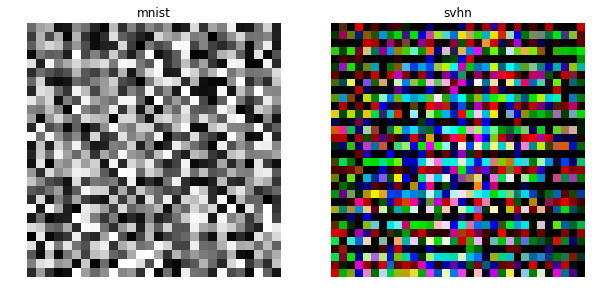

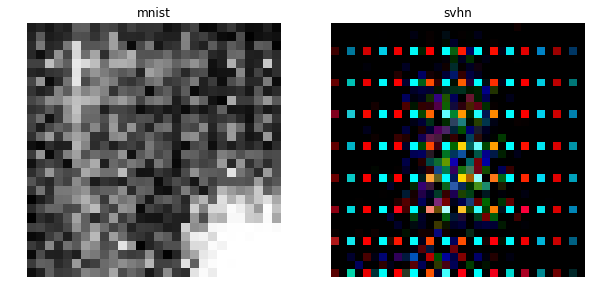

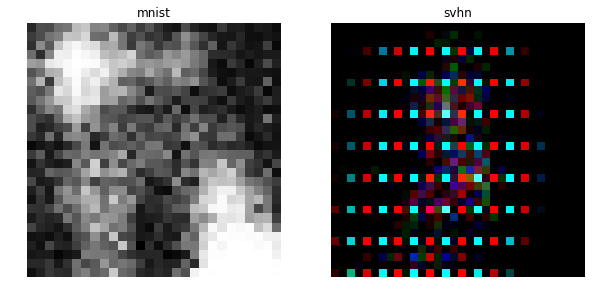

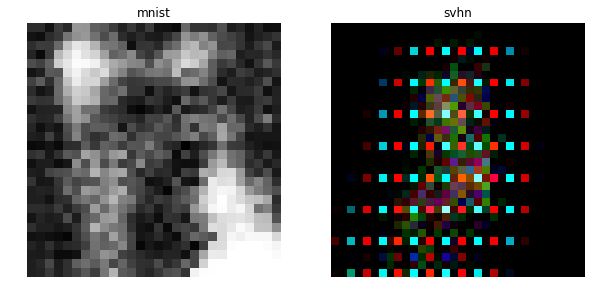

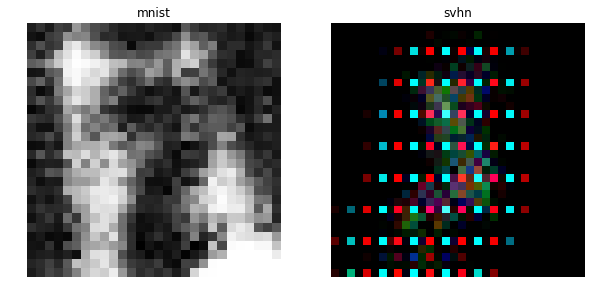

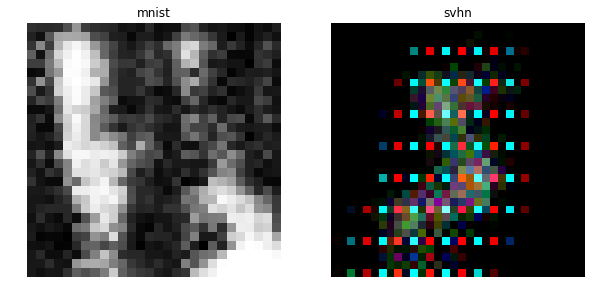

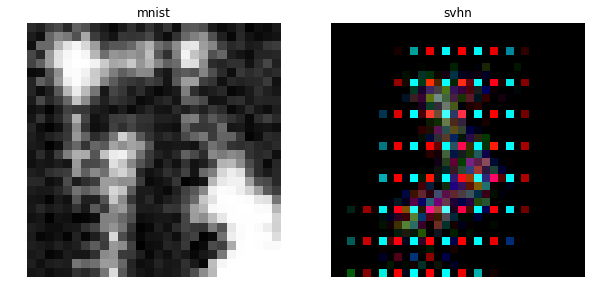

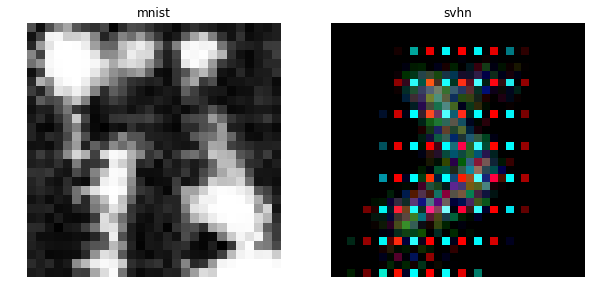

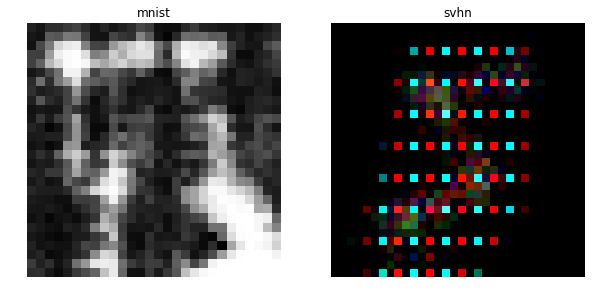

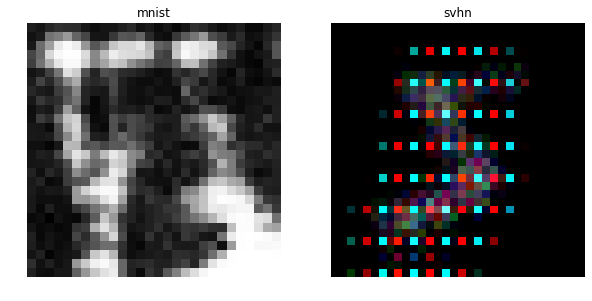

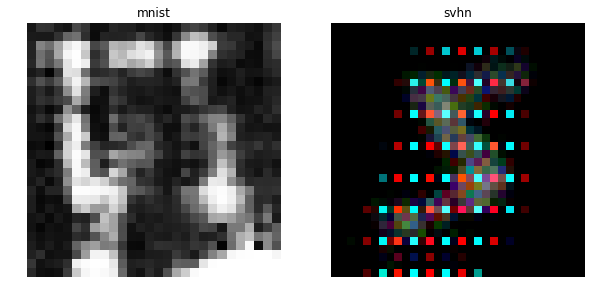

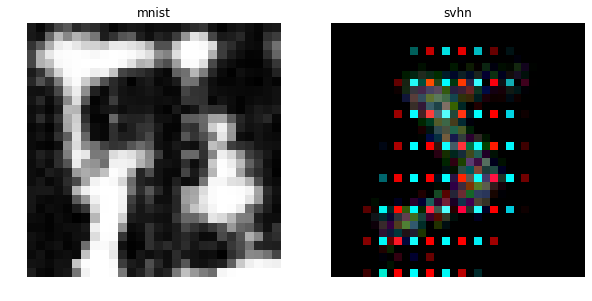

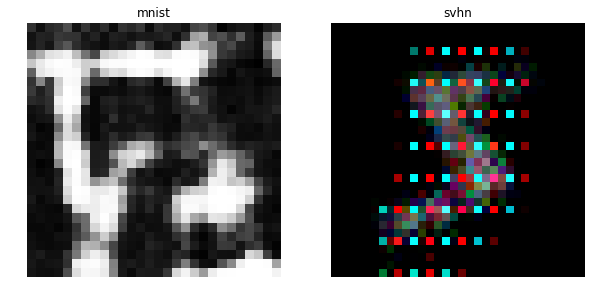

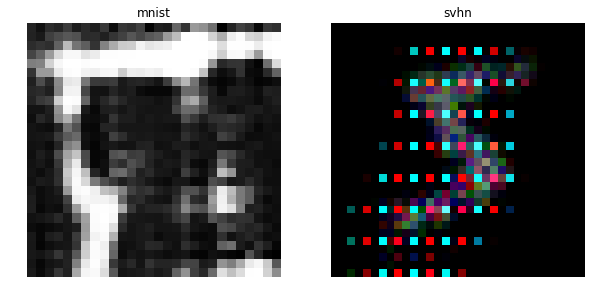

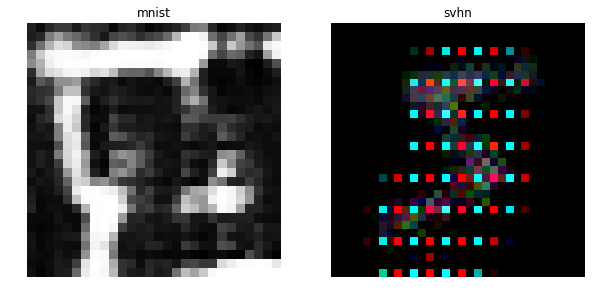

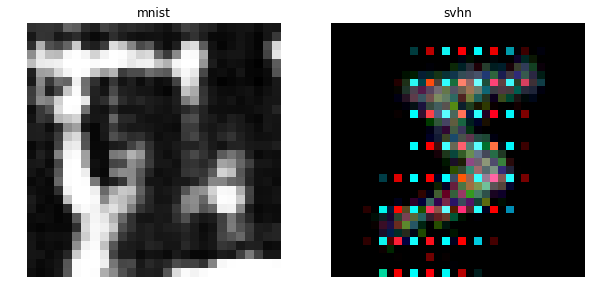

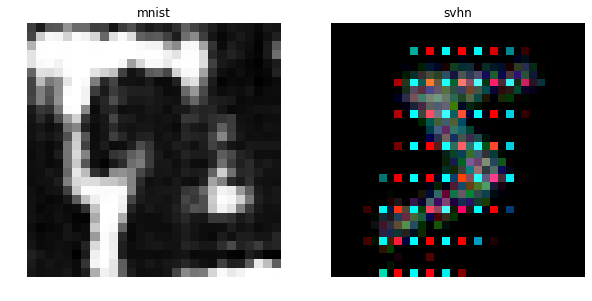

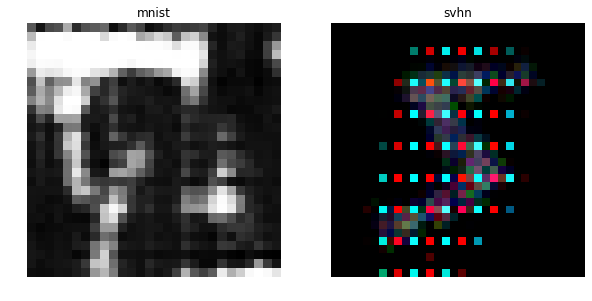

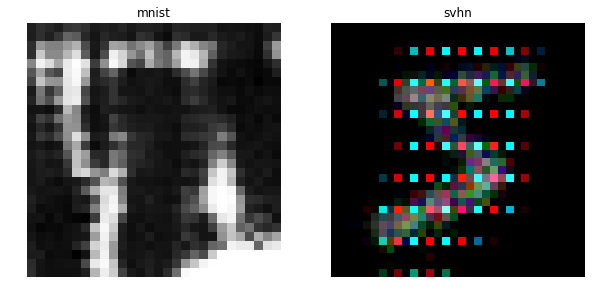

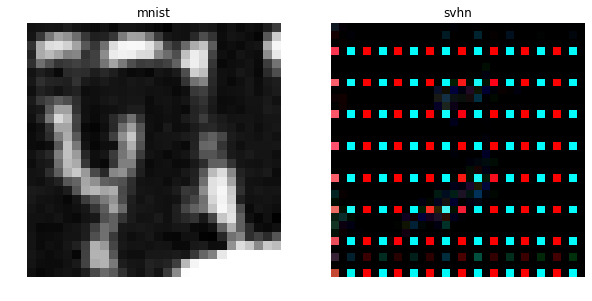

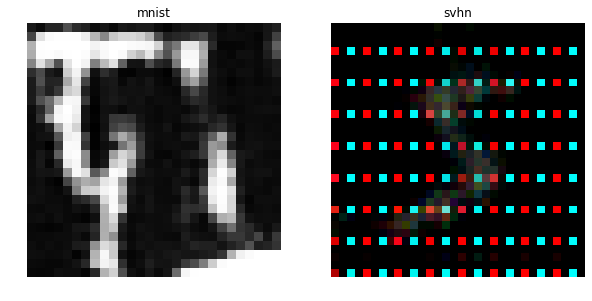

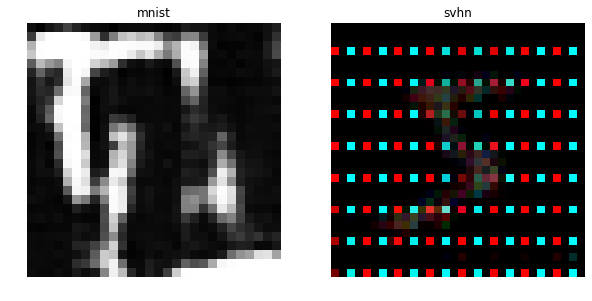

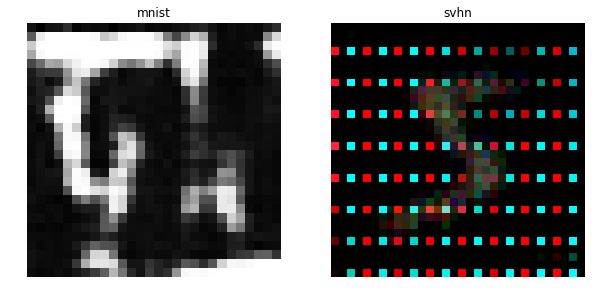

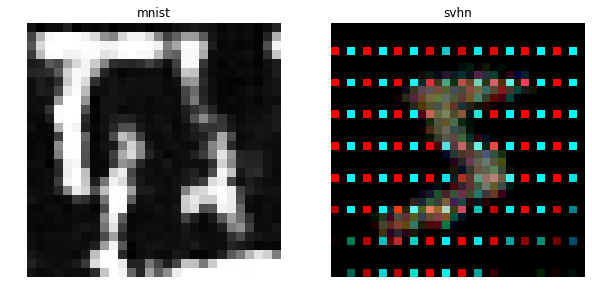

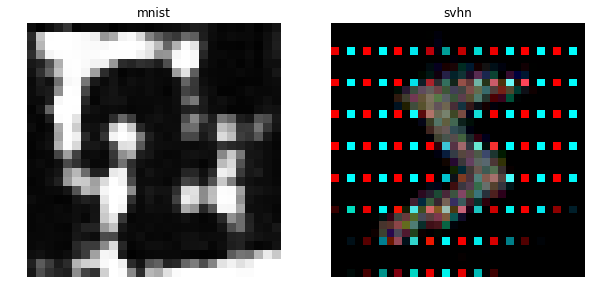

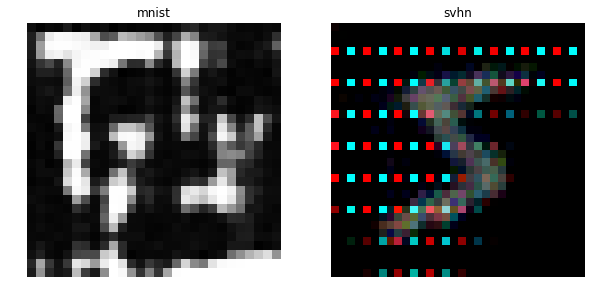

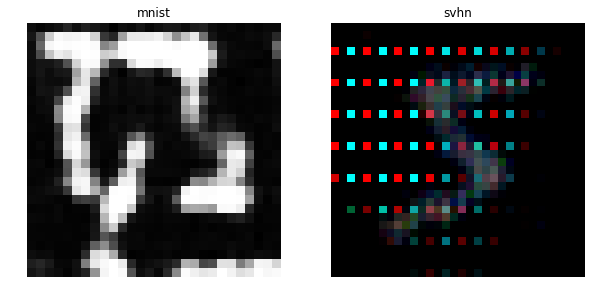

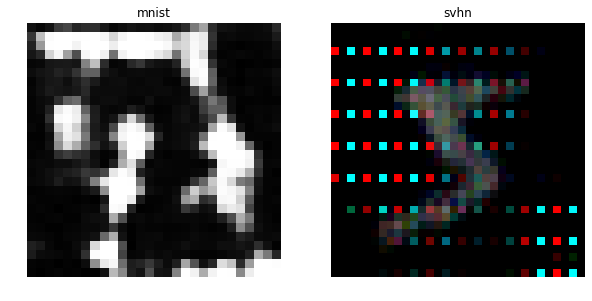

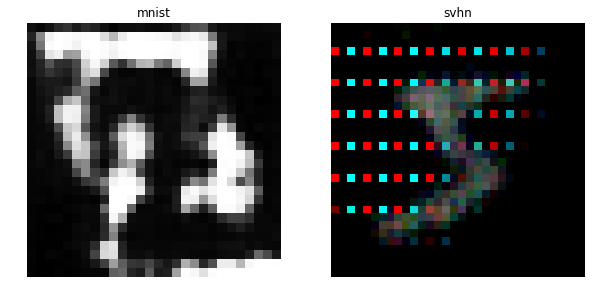

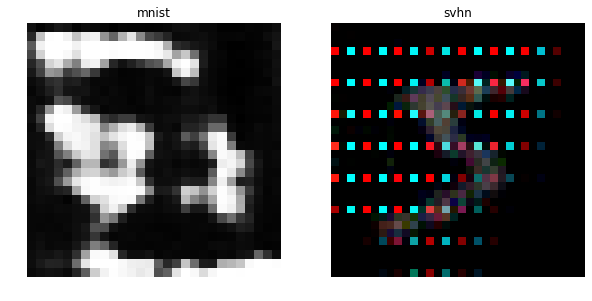

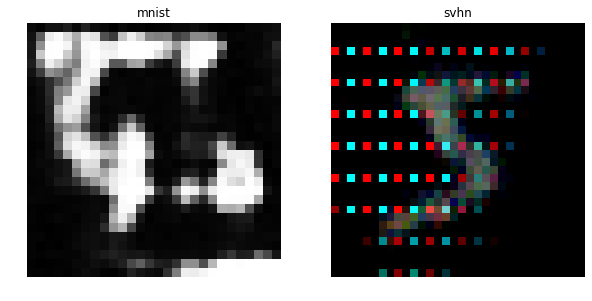

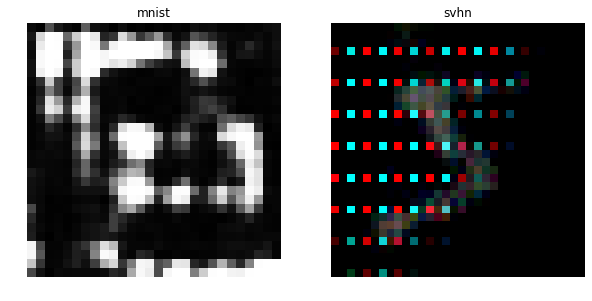

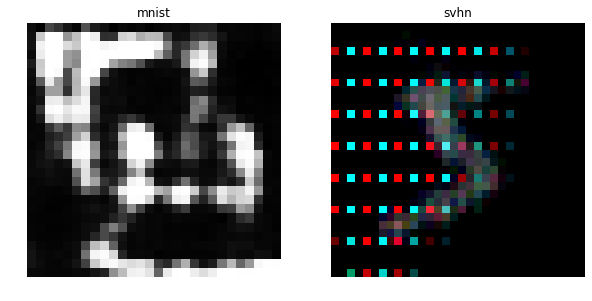

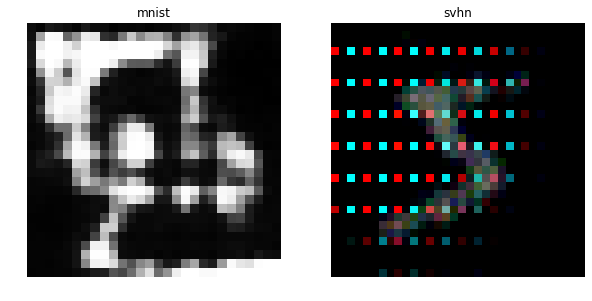

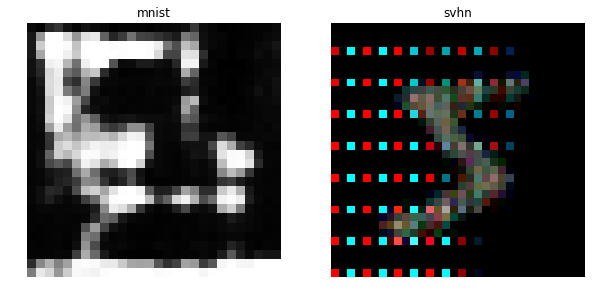

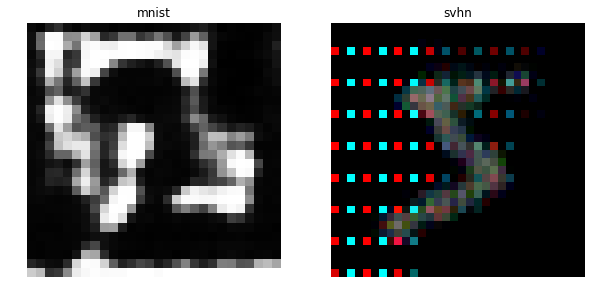

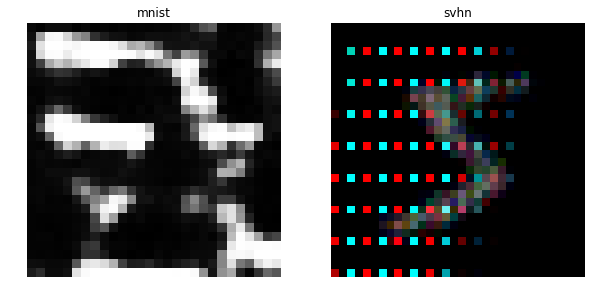

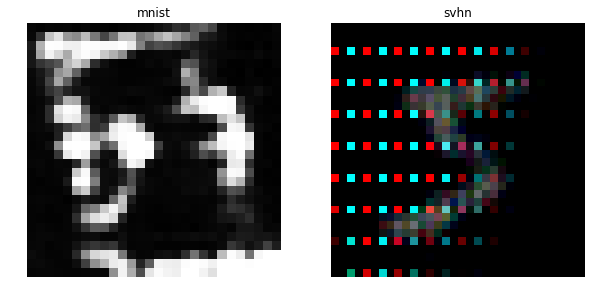

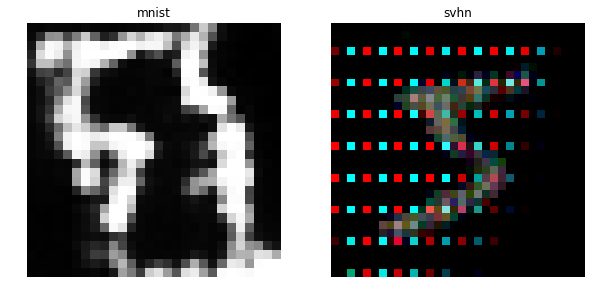

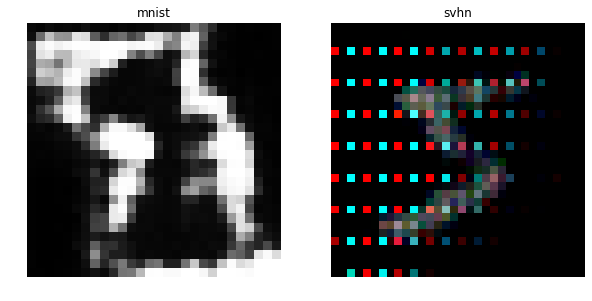

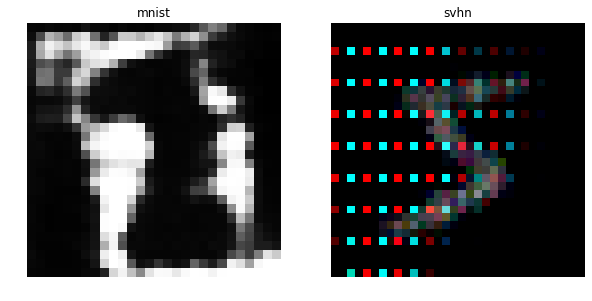

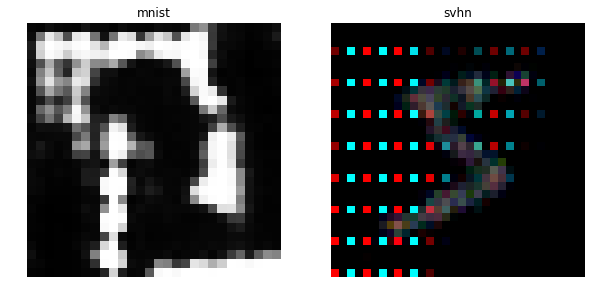

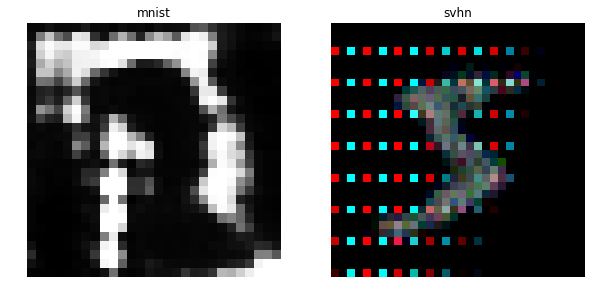

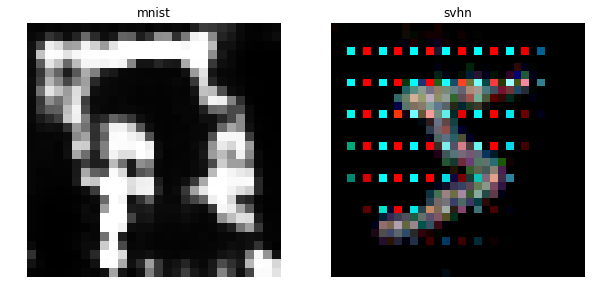

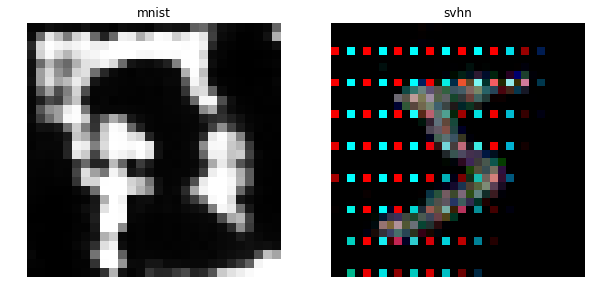

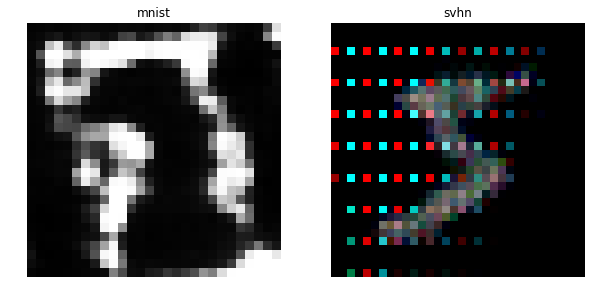

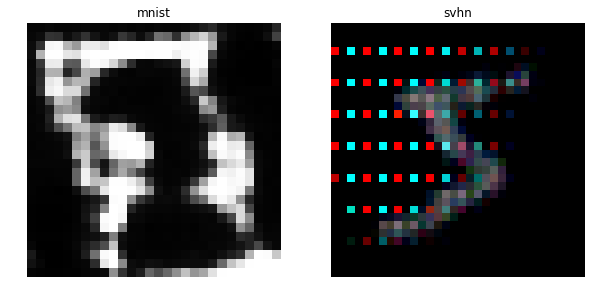

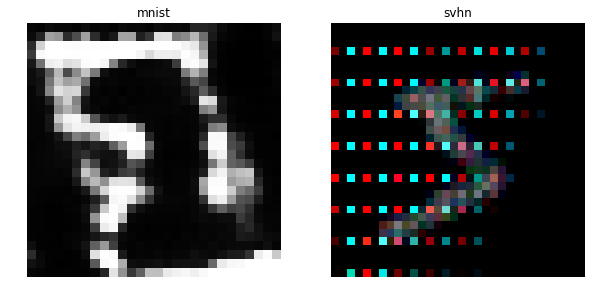

In [17]:
# TODO: incorporate image buffer
# TODO: incorporate linear decay of learning rate in the second half of epochs
# TODO: save trained weights

# TODO: probably don't use 200 epochs - runtime might be astronomical!
epoch_nr = 200
decay_threshold = epoch_nr // 2
learn_rate = 0.0002

# TODO: not set but tensor
#generated_svhn_buffer = tf.Tensor()
#generated_mnist_buffer = tf.Tensor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
    #TODO: maybe change (e.g. random test images for visualisation)
    #test_mnist = mnist_images[0:10,:,:,:]
    #test_svhn = svhn_images[0:10,:,:,:]
    test_mnist = mnist_images[0:1,:,:,:]
    test_svhn = svhn_images[0:1,:,:,:]

    for cur_epoch in range(epoch_nr):
        
        # decay of the learning rate after the first half of episodes
        # > instead of >= because learning rate of last epoch should not be zero
        if cur_epoch > decay_threshold:
            learn_rate -= (learn_rate / decay_threshold)
            
        print("hello")
        sess.run((training_init_op_mnist, training_init_op_svhn))
        while True:
            #print("while")
            try:
                #TODO: update generator with 1 image and discriminator with image buffer
                summaries, _, _, _, _, = sess.run((merged_summaries,
                                                 dy_training_step,
                                                 dx_training_step,
                                                 g_training_step,
                                                 f_training_step),
                                                 feed_dict={
                                                     learning_rate: learn_rate
                                                 })
                
                generated_svhn, generated_mnist = sess.run((svhn_generated, mnist_generated), feed_dict={svhn_real:test_svhn,
                                                                                                        mnist_real:test_mnist})
                if global_step % 100 == 0:
                    generated_mnist_img = generated_mnist[0, :, :, 0]
                    #print(generated_mnist_img.shape)
                    #floored_mnist_img = np.floor((generated_mnist_img + 1) * 0.5 * 255)
                    #im_mnist = Image.fromarray(floored_mnist_img, mode="L")
                    #im = im.convert("L")
                    #im_mnist.save("./images/mnist/{}.png".format(global_step))

                    generated_svhn_img = generated_svhn[0, :, :, 0:3]
                    #print(generated_svhn_img.shape)
                    #floored_svhn_img = np.floor((generated_svhn_img + 1) * 0.5 * 255)
                    #im_svhn = Image.fromarray(floored_svhn_img, mode="RGB")
                    #im = im.convert("RGB")
                    #im_svhn.save("./images/svhn/{}.png".format(global_step))
                    
                    fig, ax = plt.subplots(1,2,figsize=(10,10))
                    ax[0].imshow(generated_mnist_img, cmap="gray")
                    ax[0].axis('off')
                    ax[0].set_title("mnist")
                    
                    ax[1].imshow(generated_svhn_img)
                    ax[1].axis('off')
                    ax[1].set_title("svhn")

                    #ax[1].imshow(generated_svhn_img)
                    #ax[1].axis('off')
                   # ax[1].set_title("svhn")

                #test_images = sess.run((generated_images), feed_dict={z:test_z})
                #if global_step % 100 == 0:
                    #for i in range(generated_images_n):
                        #test_generated = test_images[i,:,:,0]
                        #test_generated = np.floor((test_generated + 1) * 0.5 * 255)
                        #im = Image.fromarray(test_generated)
                        #im = im.convert("L")
                        #im.save("./images/{}_{}.png".format(global_step,i))
                writer.add_summary(summaries, global_step = global_step)
                global_step += 1
            except tf.errors.OutOfRangeError:
                break

In [ ]:
print("no crash - yay")